## `tenforty` Package Demo

This notebook contains several examples of the tenforty tax package to play with.

In [1]:
!pip install -U tenforty seaborn > /tmp/pip-install.log 2>&1

In [2]:
import polars as pl
import seaborn.objects as so

from tenforty import evaluate_return, evaluate_returns
from tenforty.models import OTSFilingStatus, OTSState, OTSYear

For convenience we show the available states, years, and filing statuses:

In [3]:
print(f"Supported states: {[e.value for e in OTSState]}")
print(f"Supported tax years: {[e.value for e in OTSYear]}")
print(f"Filing statuses: {[e.value for e in OTSFilingStatus]}")

Supported states: [None, 'CA', 'MA', 'NY', 'AK', 'FL', 'NV', 'SD', 'TX', 'WA', 'WY']
Supported tax years: [2018, 2019, 2020, 2021, 2022, 2023, 2024]
Filing statuses: ['Single', 'Married/Joint', 'Head_of_House', 'Married/Sep', 'Widow(er)']


`evaluate_return` evaluates a single return:

In [4]:
evaluate_return(
    w2_income=100_000, state="CA", filing_status="Married/Joint", num_dependents=2
).model_dump()

{'total_tax': 9304.0,
 'federal_adjusted_gross_income': 100000.0,
 'federal_effective_tax_rate': 11.3,
 'federal_tax_bracket': 12.0,
 'federal_taxable_income': 70800.0,
 'federal_amt': 0.0,
 'federal_total_tax': 8035.0,
 'state_adjusted_gross_income': 100000.0,
 'state_taxable_income': 88920.0,
 'state_total_tax': 1269.0,
 'state_tax_bracket': 6.0,
 'state_effective_tax_rate': 2.8}

`evaluate_returns` evaluates a grid of return inputs, producing a table:

In [5]:
evaluate_returns(
    w2_income=list(range(50_000, 250_001, 50_000)),
    state="CA",
    filing_status="Married/Joint",
    num_dependents=2,
)[
    [
        "w2_income",
        "federal_effective_tax_rate",
        "federal_tax_bracket",
        "state_effective_tax_rate",
        "state_tax_bracket",
    ]
]

w2_income,federal_effective_tax_rate,federal_tax_bracket,state_effective_tax_rate,state_tax_bracket
i64,f64,f64,f64,f64
50000,10.0,12.0,1.5,2.0
100000,11.4,12.0,2.9,6.0
150000,14.3,22.0,4.5,9.3
200000,16.6,22.0,5.8,9.3
250000,18.1,24.0,6.5,9.3


The output of `evaluate_returns` is a polars.DataFrame, so you can readily visualize the results:

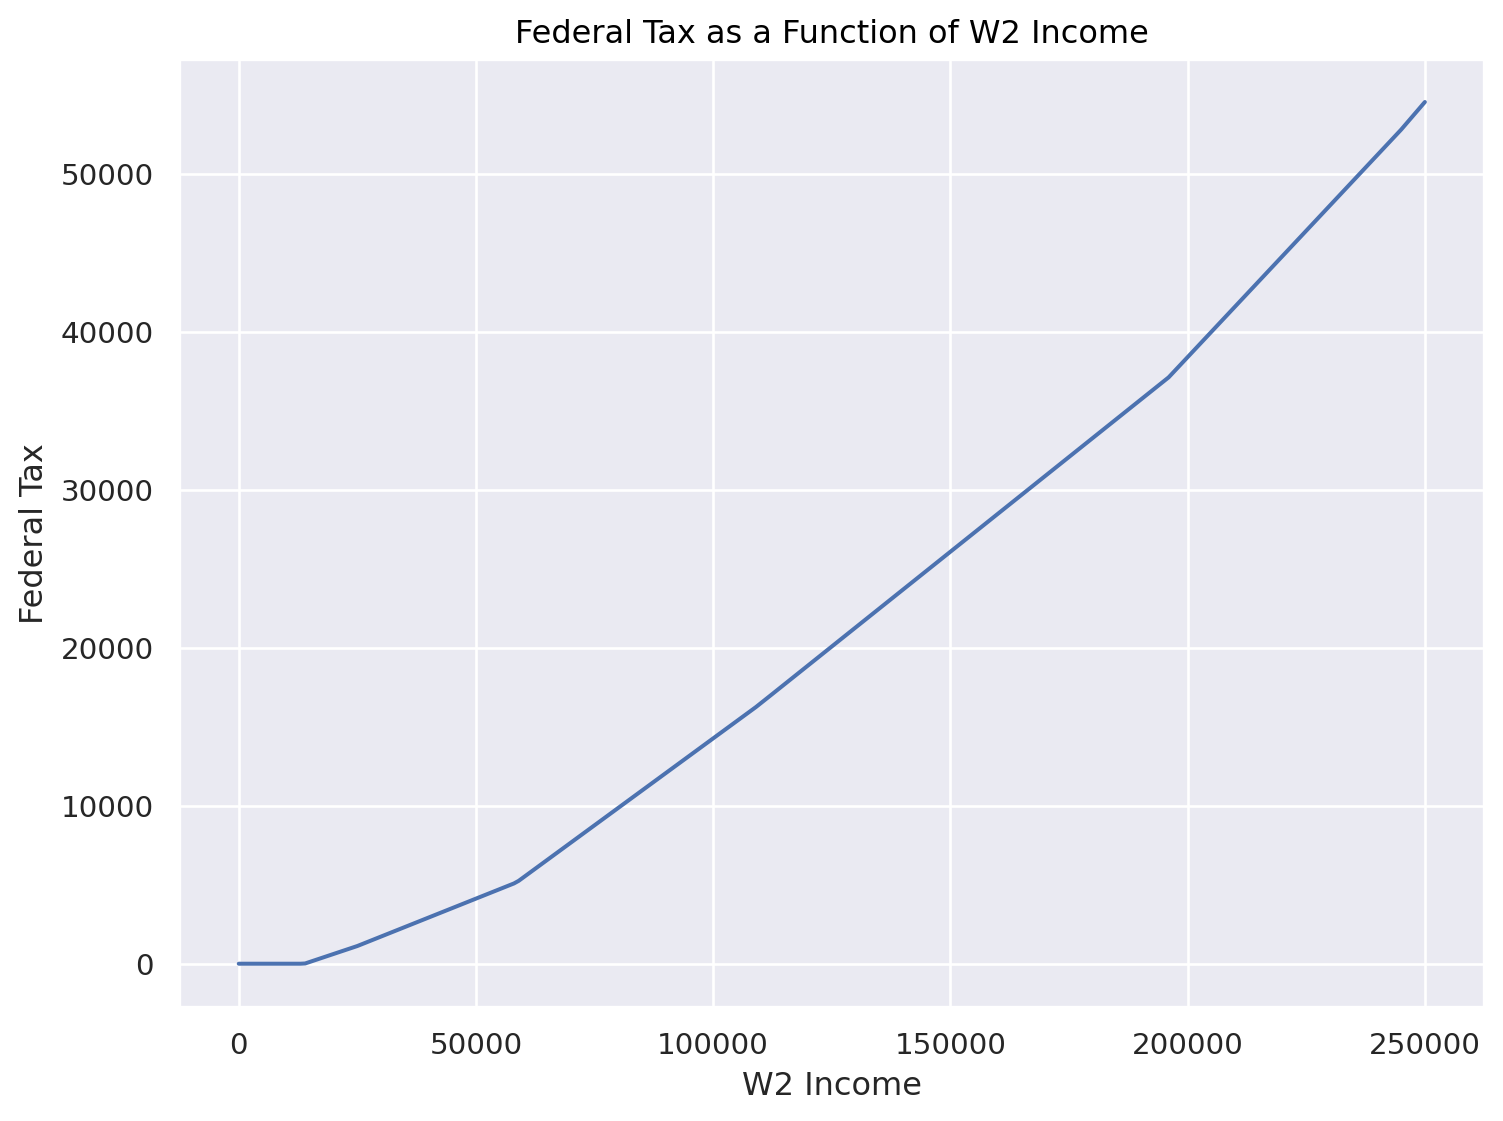

In [6]:
df = evaluate_returns(w2_income=list(range(0, 250_001, 1_000)))

(
    so.Plot(df, x="w2_income", y="total_tax")
    .add(so.Line())
    .label(
        x="W2 Income", y="Federal Tax", title="Federal Tax as a Function of W2 Income"
    )
    .layout(size=(8, 6))
)

`evaluate_returns` supports common types of income, including capital gains:

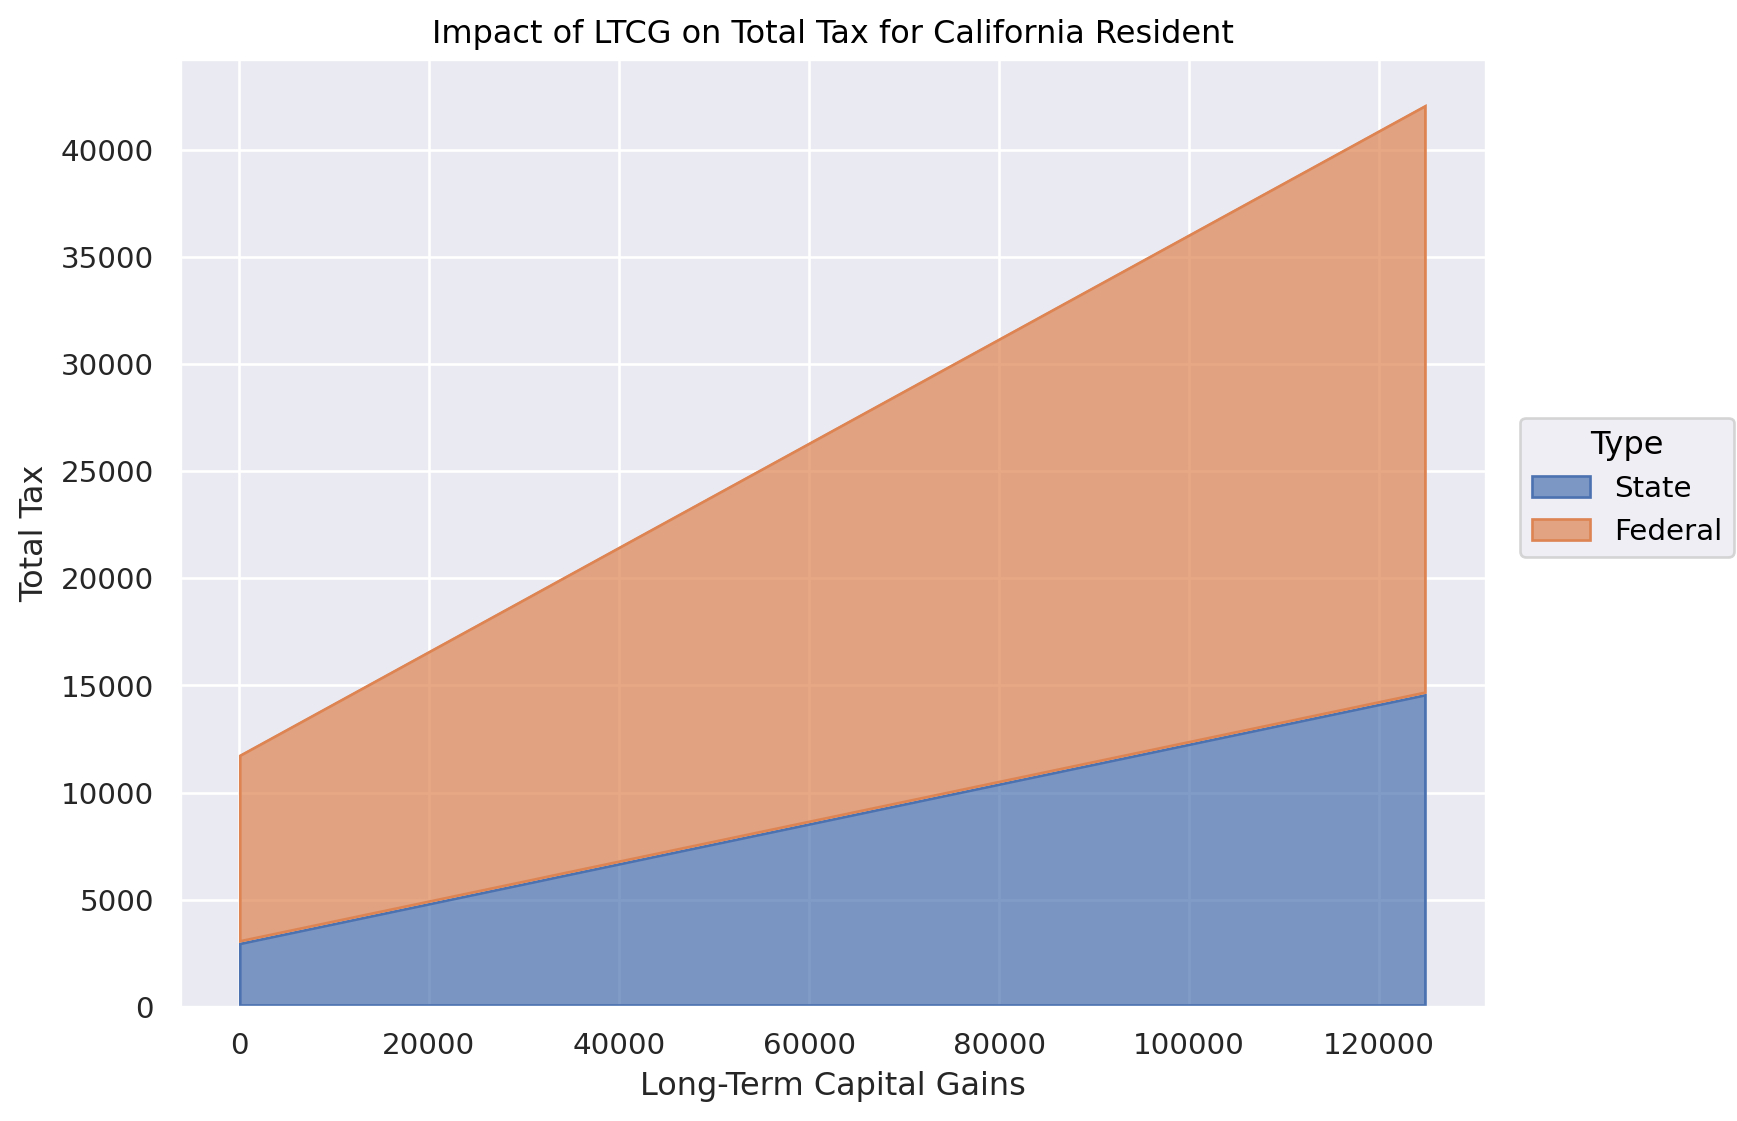

In [7]:
df = (
    evaluate_returns(
        w2_income=75_000,
        state="CA",
        long_term_capital_gains=list(range(0, 125_001, 5000)),
    )
    .select(["long_term_capital_gains", "state_total_tax", "federal_total_tax"])
    .unpivot(index="long_term_capital_gains", variable_name="Type", value_name="tax")
    .with_columns(
        pl.col("Type").replace(
            {"state_total_tax": "State", "federal_total_tax": "Federal"}
        )
    )
)

(
    so.Plot(df, x="long_term_capital_gains", y="tax", color="Type")
    .add(so.Area(alpha=0.7), so.Stack())
    .label(
        x="Long-Term Capital Gains",
        y="Total Tax",
        title="Impact of LTCG on Total Tax for California Resident",
    )
    .layout(size=(8, 6))
)